In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
import model_predict
import random

# 指定支持中文的字体，例如SimHei或者Microsoft YaHei
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

random.seed(123)

In [2]:
series, scaler = model_predict.read_data_series(scale=True, file_index=1)
features, targets = model_predict.gen_xgboost_data(series)

时间序列连贯


In [6]:
(mae_best, mae_best_i, r2_best, r2_best_i)

(9.501729742270388, 61, 0.7207832900006236, 65)

MSE: 0.00
MAE: 0.05
R^2: nan
MAPE: 0.00


C:\Users\h1318\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_regression.py:996: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


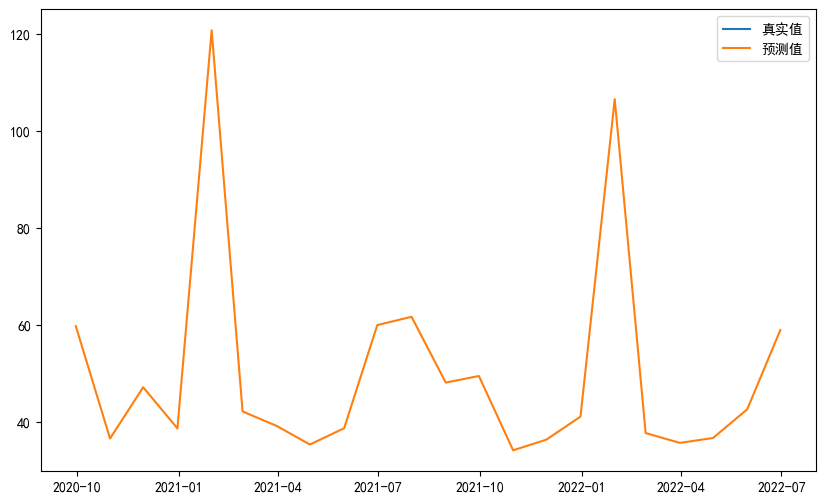

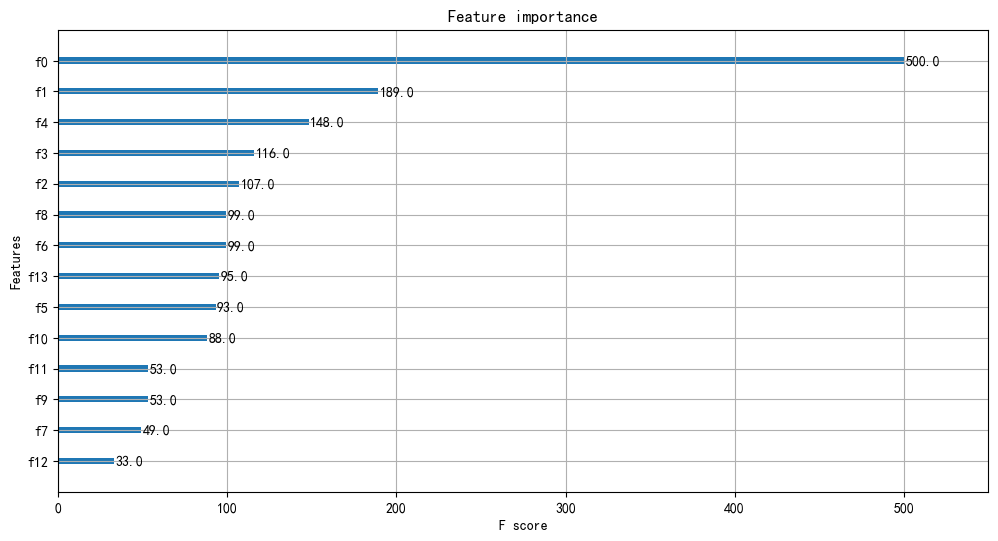

In [18]:
# 划分训练集和测试集  
# X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=12/len(features), shuffle=False)
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=65)

# 创建XGBoost模型  
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, gamma=0, subsample=0.75,  
                        colsample_bytree=1, max_depth=7)

# 训练模型  
results = model.fit(X_train, y_train)

results, _ = model_predict.predict_to_future_xgboost(model, series, scaler, months=22, last_months=1)

In [11]:
results.to_excel('results.xlsx')

In [7]:
# 预测和评估  
y_pred = model.predict(features)  
if scaler != None:
    y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1)).reshape(-1)
    targets_inv = scaler.inverse_transform(targets.reshape(-1, 1)).reshape(-1)
else:
    targets_inv = targets
    y_pred_inv = y_pred

# 绘制预测结果
plt.figure(figsize=(12, 6))
plt.plot(targets_inv, label='实际销量')
plt.plot(y_pred_inv, label='预测销量')
plt.legend()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'values'